In [1]:
import os
import sys

# change the directory to the root of the project
path = os.path.dirname(os.getcwd())
sys.path.append(path)

from PIL import Image
import torch
from models.models import NutriFusionNet
from torchvision import transforms
import pandas as pd
import numpy as np


In [30]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#============== Load the model ==============#
embeddings = torch.load(f'../utils/embeddings/ingredient_embeddings_gat_v2.pt', map_location=device, weights_only=True)

model = NutriFusionNet(num_ingr=199, backbone='vit', ingredient_embedding=embeddings, lstm_layers=2, num_layers=2, hidden_dim=512).to(device)
model.load_state_dict(torch.load("../models/checkpoints/NutriFusionNet_vit_2lstm_2attn_gat_v2_pretrained_da_16_75_25.pth", map_location=device, weights_only=True))

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device)

#============== Load the ingredient metadata ==============#
dataset_path = '../../data/nutrition5k_reconstructed/'

image_path = os.path.join(dataset_path, 'images')
ingr_mata = os.path.join(dataset_path, 'metadata/ingredients_metadata.csv')
ingr_df = pd.read_csv(ingr_mata)


# Load the ingredient metadata
test_ingr_dataset_path = '../utils/data/test_labels_ingr_log.csv'
train_ingr_dataset_path = '../utils/data/train_labels_ingr_log.csv'
val_ingr_dataset_path = '../utils/data/val_labels_ingr_log.csv'

test_df = pd.read_csv(test_ingr_dataset_path)
train_df = pd.read_csv(train_ingr_dataset_path)
val_df = pd.read_csv(val_ingr_dataset_path)

ingr_indx_df = pd.concat([test_df, train_df, val_df], ignore_index=True)

ingr_index = {}

colnames = ingr_indx_df.columns[1:-1]
for i in range(len(colnames)):
    ingr_index[i] = colnames[i]

# ingr,id,cal/g,fat(g),carb(g),protein(g)
ingr_dict = {}
for i in range(len(ingr_df)):
    ingr = ingr_df.iloc[i]['ingr']
    cal = ingr_df.iloc[i]['cal/g']
    fat = ingr_df.iloc[i]['fat(g)']
    carb = ingr_df.iloc[i]['carb(g)']
    protein = ingr_df.iloc[i]['protein(g)']
    ingr_dict[ingr] = (cal, fat, carb, protein)

#============== Inference function ==============#
def calculate_ingrdients_and_nutritional_facts(outputs, ingr_dict, ingr_index, k = 3):
    # outputs will always be (1, 199) since we are processing one image at a time
    outputs = outputs.squeeze(0).cpu().detach().numpy()
    sample_calories = 0
    sample_mass = 0
    sample_fat = 0
    sample_carbs = 0
    sample_protein = 0
    top_k_ingr = []
    
    idx = np.where(outputs > 0.15)[0]
    if len(idx) != 0:
        # Dictionary to store ingredient mass for top k selection
        ingredient_masses = {}
        for ingr_idx in idx:
            mass = outputs[ingr_idx]
            # Convert back from log scale
            mass = np.exp(mass) - 1
            ingr_name = ingr_index[ingr_idx]
            cal, fat, carb, protein = ingr_dict[ingr_name]
            
            sample_calories += mass * cal
            sample_fat += mass * fat
            sample_carbs += mass * carb
            sample_protein += mass * protein
            sample_mass += mass
                        
            # Store ingredient name and mass
            ingredient_masses[ingr_name] = mass
            
        # Sort ingredients by mass and select the top 3
        sorted_ingredients = sorted(ingredient_masses.items(), key=lambda x: x[1], reverse=True)
        top_k_ingr = [ingr for ingr, _ in sorted_ingredients[:k]]
    else:
        top_k_ingr = ["No ingredients detected"]
        
    return {
        "calories": sample_calories,
        "mass": sample_mass,
        "fat": sample_fat,
        "carbs": sample_carbs,
        "protein": sample_protein,
        "top_k_ingr": top_k_ingr
    }
    
#============== Process the image ==============#
# Function to process the image and predict
def process_image(image_file = None, k = 2):

    # Preprocess the image
    image_tensor = preprocess_image(image_file)
    outputs = model(image_tensor)
    results = calculate_ingrdients_and_nutritional_facts(outputs, ingr_dict, ingr_index, k)
    ingredients = results["top_k_ingr"]
    nutritional_facts = {
        "Calories": results["calories"],
        "Total Mass (g)": results["mass"],
        "Fat (g)": results["fat"],
        "Carbs (g)": results["carbs"],
        "Protein (g)": results["protein"],
    }
    
    return ingredients, nutritional_facts

#============== Test ==============#
image_idx = os.listdir(image_path)

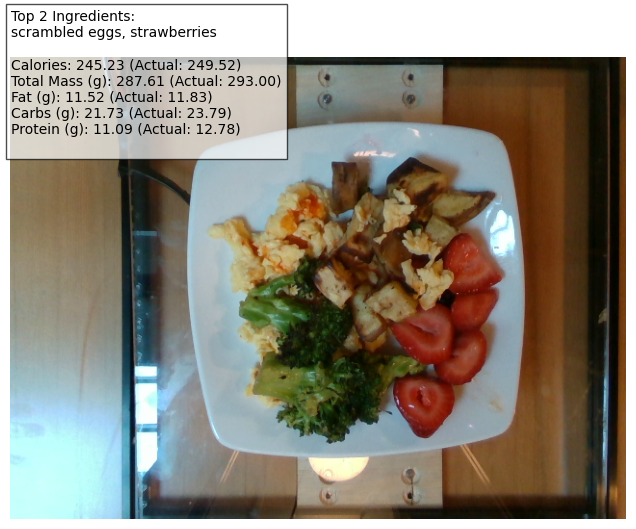

In [ ]:
import random
import matplotlib.pyplot as plt
# randomly select 16 images

actual_label_path = "../../data/nutrition5k_reconstructed/labels/labels.csv"
actual_label_dict = {}

with open(actual_label_path, 'r') as f:
    next(f)
    for line in f:
        line = line.strip().split(',')
        actual_label_dict[line[0]] = {
            "Calories": float(line[1]),
            "Total Mass (g)": float(line[2]),
            "Fat (g)": float(line[3]),
            "Carbs (g)": float(line[4]),
            "Protein (g)": float(line[5])
        }

selected_images = random.sample(image_idx, 16)
k = 2

for image in selected_images:
    image_file = os.path.join(image_path, image)
    # Display the image
    img = Image.open(image_file)
    plt.figure(figsize=(8, 6))  # Set figure size
    plt.imshow(img)
    plt.axis('off')  # Hide axes for clarity

    # Extract image ID
    image_id = image.split(".")[0]
    
    # Process the image
    ingredients, nutritional_facts = process_image(image_file, k)
    
    # Title: Show image name
    plt.title(f"{image_id}", fontsize=12, loc='right')

    # Add information overlay
    info_text = f"Top {k} Ingredients:\n" + ", ".join(ingredients) + "\n\n"
    for key, value in nutritional_facts.items():
        actual_value = actual_label_dict[image_id][key]
        info_text += f"{key}: {value:.2f} (Actual: {actual_value:.2f})\n"

    # Display the text on the figure
    plt.text(
        1,  # X position
        -50,  # Y position (adjust to your needs)
        info_text,
        fontsize=10,
        color='black',
        backgroundcolor='white',
        ha='left',
        va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Optional text box
    )

    plt.show()
